In [160]:
IJulia.load("utils.jl")

## Todo list

Ratio of missing pixels : **f=[0, 0.1, 0.2, 0.4, 0.5, 0.8, 0.9]**

* [x] Algo PCD, Caution: the persistent chain should start from random values
* [x] Make the code for fixed mask of the pixels.
* Adding reconstruction error of images with missing pixels (during the learning)
  * Pinning the ground truth and going to convergence with and without Mean-Field (when using MC, using p(v|h))
  * Non-pinning, and going to convergence with and without MF (when using MC, using p(v|h))
* After the learning, showing Mean-field fixed point
  * [x] starting from 10 images
  * starting from 10 random initial conditions
  * [x] starting from 10 images with missing pixels (for different fractions of missing pixels : f=[0.2,0.5,0.8]), pinning the ground truth
  * [x] starting from 10 images with missing pixels (for different fractions of missing pixels : f=[0.2,0.5,0.8]), not pinning the ground truth
  * [x] Doing Monte-Carlo sampling for 100 images for 100 timesteps, then plotting p(v|h)

* Yeast data
  * plot 10 samples, and the reconstruction done on the same samples with some percentage of missing input.
  * same, but plotting the difference node by node of the ground truth and the reconstructed sample
  * Characterizing unbalanced 
  * Step 1: not using "label nodes", and try to understand of the missing input procedure works
  * Step 2: No missing input on the signal, only on the "label nodes"
  * Step 3: missing input on all nodes

## Code imports and definitions, skip down for plots

In [300]:
using MLDatasets
using Images
using Plots

include("utils.jl")
include("hyper_search.jl")
include("../rbm/mf-rbm/mf.jl")

pyplot();

In [301]:
function generate_fps(rbm, X; n_iter = 1, ϵ = 1e-8)
  fp_iter(rbm, Float64.(X), tap_v_fp, tap_h_fp, eps = ϵ, max_iter = n_iter)
end

function generate_fps(rbm, X, mask; n_iter = 1, ϵ = 1e-8)
  lossy = get_lossy(X, mask)
  obs = setdiff(1:size(X, 1), mask)
  
  keep = repeat(obs, outer = (1, size(X, 2)))
    
  mh = []

  for i = 1:n_iter
    lossy, mh = generate_fps(rbm, lossy, n_iter = 1, ϵ = 1e-8)
    for j in 1:size(lossy, 2), k in 1:length(obs)
      lossy[obs[k], j] = X[obs[k], j]
    end
  end

  lossy, mh
end;

In [302]:
# parameters used
params = Dict(
  :lr => [1e-3, 1e-4, 1e-5],
  :n_epochs => [500],
  :batch_size => [20, 30, 40],
  :randomize => [true],
  :scorer => [Boltzmann.pseudo_likelihood],
  :update => [update_simple!],
  :ratio => [0, 0.0015, 0.1, 0.2, 0.4, 0.5, 0.8, 0.9, 0.95],
  :n_gibbs => [1, 3, 5]
);

In [303]:
ns = 10000

X, Y = MNIST.traindata()
X = reshape(X, 784, size(X, 3))[:, ns + 1:ns + ns]

X = 2X .- 1

dir = "models"
try
  mkdir("models")
catch end;

#train_all(IsingRBM, X, params, fn = "$dir/MNIST_")

In [304]:
ratios = params[:ratio]

models = load_all(dir, IsingRBM)

m = [filter(x ->  (x[2][:ratio] == string(r)), collect(models)) for r in ratios]

masks = [missing_mask(size(X, 1), r) for r in ratios]

scored = [score_models(m[i], (rbm, X) -> RE(rbm, X, masks[i])) for i = 1:length(ratios)];

In [305]:
function get_best(models)
  scores = map(x -> x[3], models)
  models[findmin(scores)[2]]
end

best = [get_best(models) for models in scored];

In [307]:
function seq_sampling(rbm, mask, steps, ic = 2 * rand(size(X, 1), 1))
  s = deepcopy(ic)
  gen = [(s = generate(rbm, s, n_gibbs = i); s) for i in steps]
  [ic, gen...]
end;

## Features

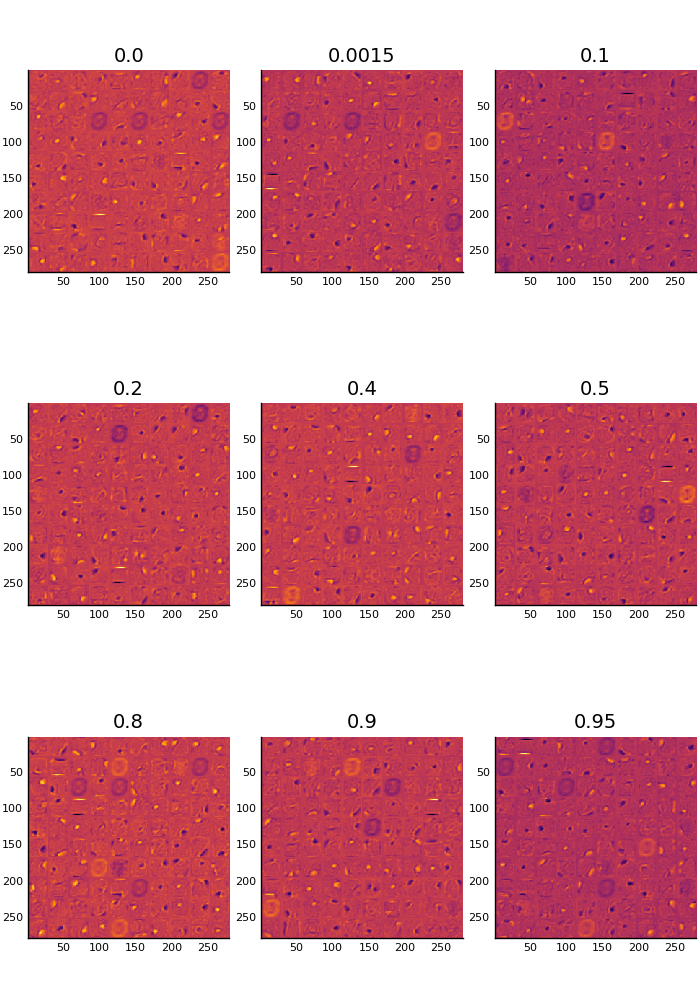

In [308]:
p = []

for i in 1:length(best)
  rbm = best[i][1]
  push!(p, plot(reshape_mnist(rbm.W'), title = ratios[i]))
end

plot(p..., size = (700, 1000))

## Reconstruction error

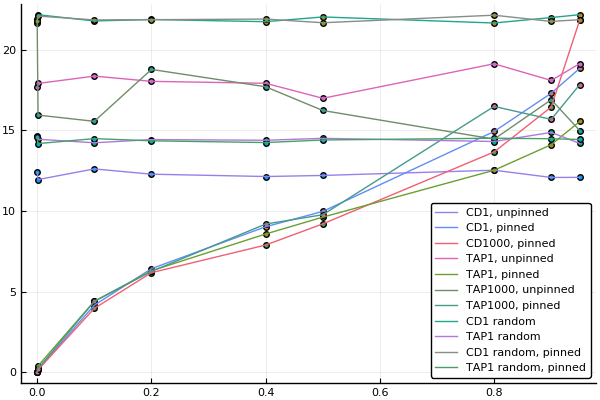

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

In [319]:
random = IsingRBM(size(X, 1), 100; X = X)

generators = [
    ((rbm, X, mask) -> generate(rbm, X, n_gibbs = 1), "CD1, unpinned"),
    ((rbm, X, mask) -> generate(rbm, X, mask, n_gibbs = 1), "CD1, pinned"),
    ((rbm, X, mask) -> generate(rbm, X, mask, n_gibbs = 1000), "CD1000, pinned"),
    ((rbm, X, mask) -> generate_fps(rbm, X, n_iter = 1)[1], "TAP1, unpinned"),
    ((rbm, X, mask) -> generate_fps(rbm, X, mask, n_iter = 1)[1], "TAP1, pinned"),
    ((rbm, X, mask) -> generate_fps(rbm, X, n_iter = 1000)[1], "TAP1000, unpinned"),
    ((rbm, X, mask) -> generate_fps(rbm, X, mask, n_iter = 1000)[1], "TAP1000, pinned"),
    ((rbm, X, mask) -> generate(random, X, n_gibbs = 1), "CD1 random"),
    ((rbm, X, mask) -> generate_fps(random, X, n_iter = 1)[1], "TAP1 random"),
    ((rbm, X, mask) -> generate(random, X, n_gibbs = 1), "CD1 random, pinned"),
    ((rbm, X, mask) -> generate_fps(random, X, n_iter = 1)[1], "TAP1 random, pinned")
]

function RE_archetype(rbm::AbstractRBM{T,V,H}, X, mask, generator) where {T,V,H}
  gen = generator(rbm, T.(X), mask)
  mean((norm(gen[:, i] - X[:, i]) for i = 1:size(X, 2)))
end

masks = [missing_mask(size(X, 1), r) for r in ratios]

REs = [[RE_archetype(best[i][1], X[:, rand(1:ns, 100)], masks[i], generator) for i = 1:length(best)] for (generator, lab) in generators]
labs = [lab for (_, lab) in generators]

labs = reshape(labs, 1, length(labs))

scatter(ratios, hcat(REs...), label = "")
plot!(ratios, hcat(REs...), lab = labs, leg = true)

## MCMC sampling

### MCMC sampling starting from random configurations

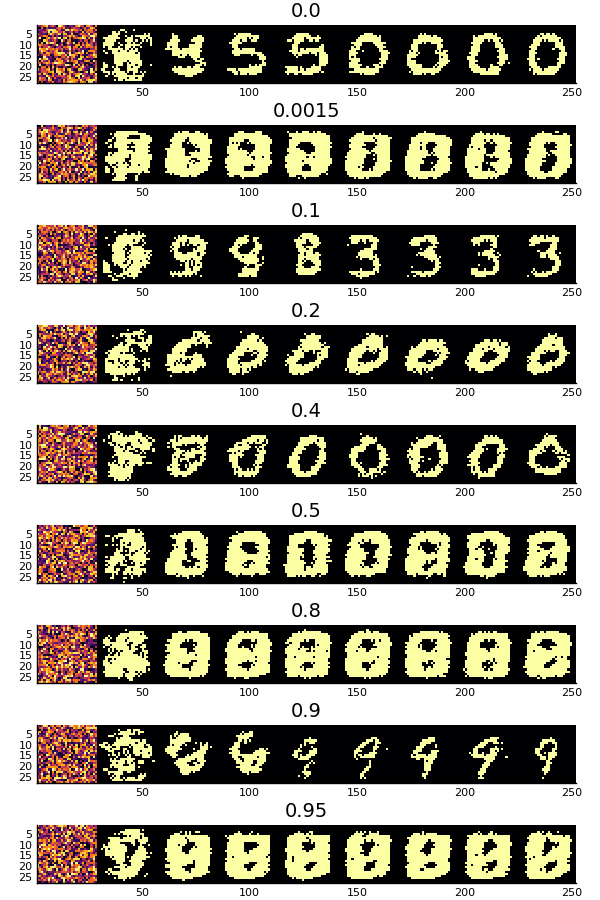

In [320]:
p = []
steps = [1, 10, 100, 1000, 1000, 1000, 7000, 10000]

for i in 1:length(best)
    samples = seq_sampling(best[i][1], masks[i], steps)
    imgs = [reshape_mnist(s, r = 1, c = 1) for s in samples]
    img = hcat(imgs...)
    push!(p, plot(img, title = ratios[i]))#plot(ps..., layout = (1, length(ps))))
end

plot(p..., layout = (length(best), 1), size = (600, 100 * length(best)))

### MCMC sampling + TAP

Running TAP equations at the end, on the results of the gibbs sampling

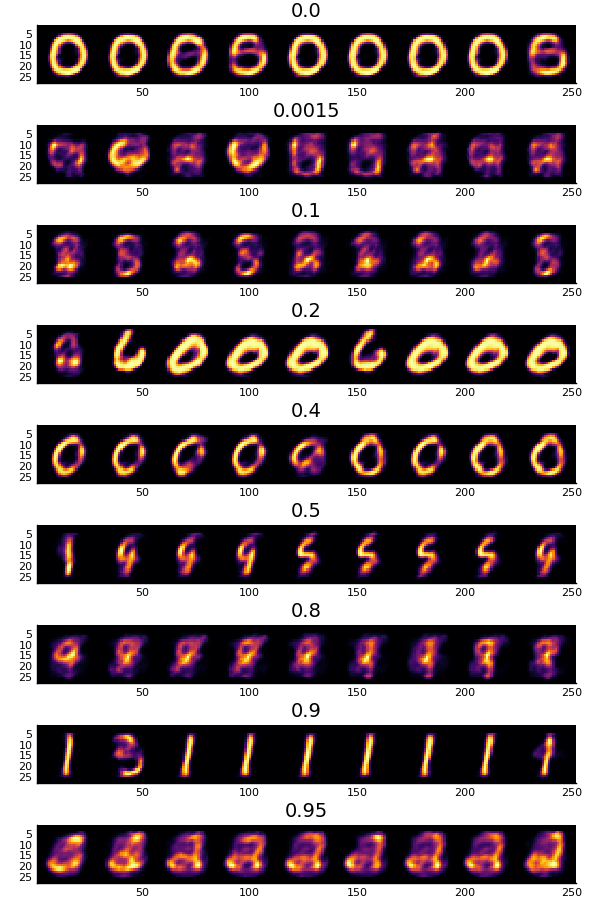

In [313]:
ϵ = 1e-8
max_iter = 1000

p = []
steps = [1, 10, 100, 1000, 1000, 1000, 7000, 10000]

for i in 1:length(best)
    samples = seq_sampling(best[i][1], masks[i], steps)
    fps = [fp_iter(best[i][1], Float64.(s), tap_v_fp, tap_h_fp, eps = ϵ, max_iter = max_iter)[1] for s in samples]
    imgs = [reshape_mnist(s, r = 1, c = 1) for s in fps]
    img = hcat(imgs...)
    push!(p, plot(img, title = ratios[i]))#plot(ps..., layout = (1, length(ps))))
end

plot(p..., layout = (length(best), 1), size = (600, 100 * length(best)))

### Alternating MCMC and TAP

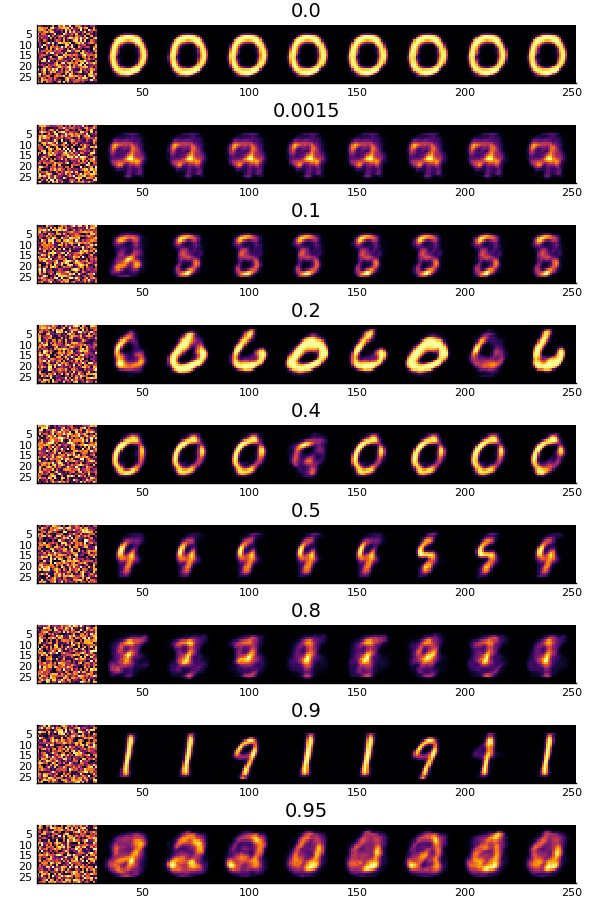

In [317]:
get_fps(rbm, s) = fp_iter(rbm, Float64.(s), tap_v_fp, tap_h_fp, eps = ϵ, max_iter = max_iter)[1] 

function seq_sampling_tap(rbm, mask, steps, ic = 2 * rand(size(X, 1), 1))
  s = deepcopy(ic)
  gen = [(s = generate(rbm, s, mask, n_gibbs = i); get_fps(rbm, s)) for i in steps]
  [ic, gen...]
end

ϵ = 1e-8
max_iter = 1000

p = []
steps = [1, 10, 100, 1000, 1000, 1000, 7000, 10000]

for i in 1:length(best)
    fps = seq_sampling_tap(best[i][1], masks[i], steps)
    imgs = [reshape_mnist(s, r = 1, c = 1) for s in fps]
    img = hcat(imgs...)
    push!(p, plot(img, title = ratios[i]))#plot(ps..., layout = (1, length(ps))))
end

plot(p..., layout = (length(best), 1), size = (600, 100 * length(best)))

## Reconstructions

Plotting on separate lines:
- original samples
- lossy samples
- non-pinned reconstructions
- pinned reconstructions

### CD-1

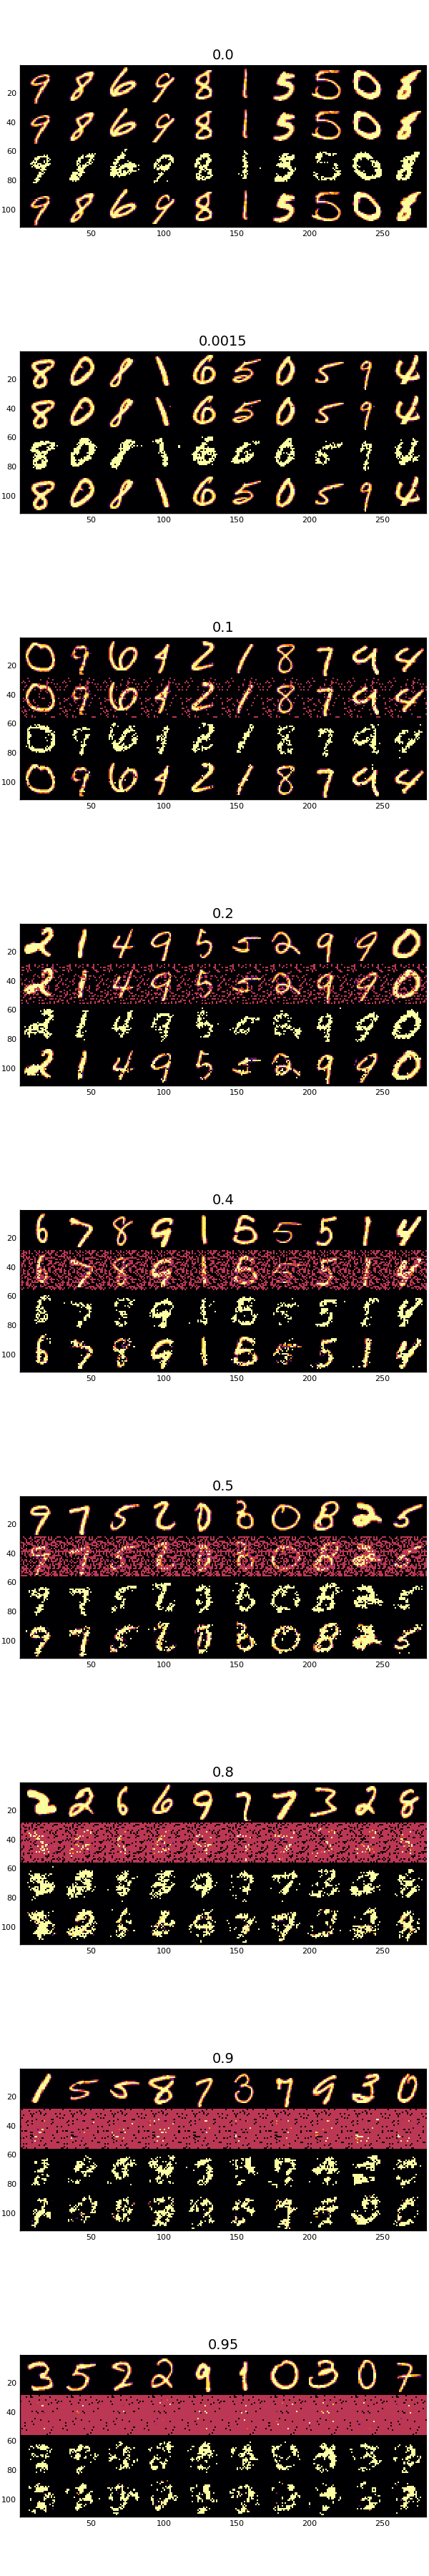

In [296]:
n = 10
p = []

for i in 1:length(best)
  s = X[:, rand(1:size(X, 2), n)]
  lossy = get_lossy(s, masks[i])
  gen = generate(best[i][1], lossy, n_gibbs = 1)
  gen_pin = generate(best[i][1], lossy, masks[i], n_gibbs = 1)
  original = reshape_mnist(s, r = 1, c = n)
  lossy_img = reshape_mnist(lossy, r = 1, c = n)
  gen_img = reshape_mnist(gen, r = 1, c = n)
  gen_pin_img = reshape_mnist(gen_pin, r = 1, c = n)
  img = vcat(original, lossy_img, gen_img, gen_pin_img)
  push!(p, plot(img, title = ratios[i]))
end

plot(p..., layout = (length(best), 1), size = (600, 400 * length(best)))

### CD-1000

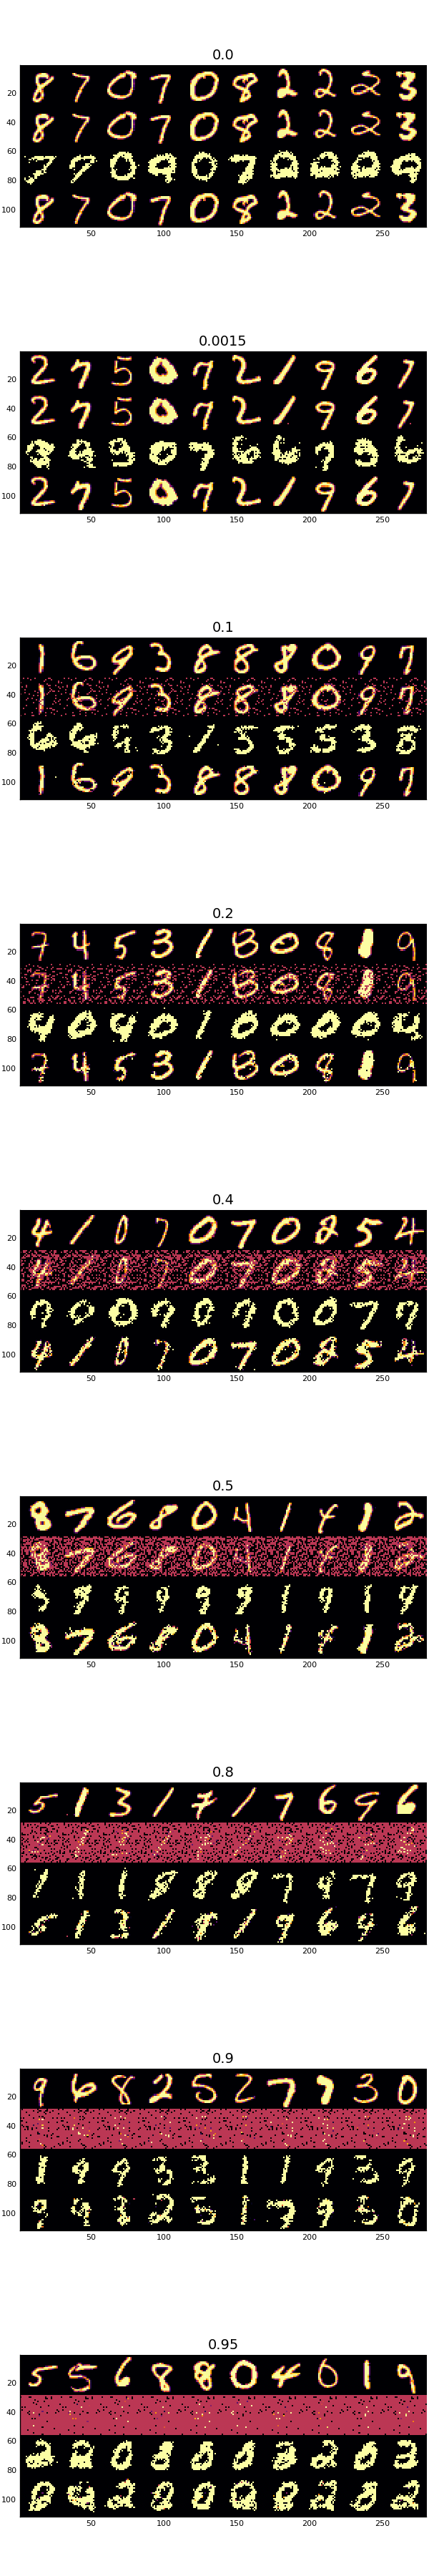

In [312]:
n_gibbs = 1000

n = 10
p = []

for i in 1:length(best)
  s = X[:, rand(1:size(X, 2), n)]
  lossy = get_lossy(s, masks[i])
  gen = generate(best[i][1], lossy, n_gibbs = n_gibbs)
  gen_pin = generate(best[i][1], lossy, masks[i], n_gibbs = n_gibbs)
  original = reshape_mnist(s, r = 1, c = n)
  lossy_img = reshape_mnist(lossy, r = 1, c = n)
  gen_img = reshape_mnist(gen, r = 1, c = n)
  gen_pin_img = reshape_mnist(gen_pin, r = 1, c = n)
  img = vcat(original, lossy_img, gen_img, gen_pin_img)
  push!(p, plot(img, title = ratios[i]))
end

plot(p..., layout = (length(best), 1), size = (600, 400 * length(best)))

### TAP-1

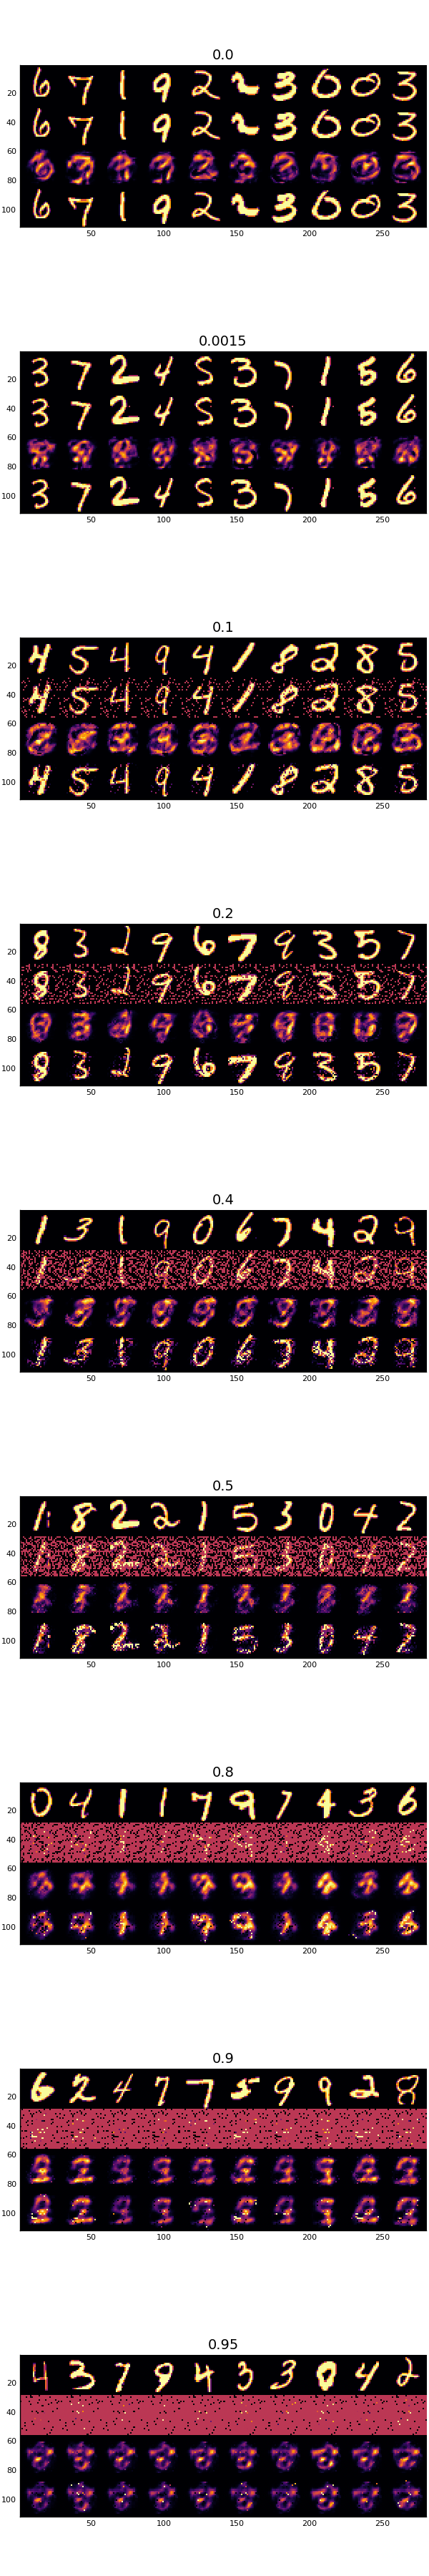

In [298]:
n = 10

ϵ = 1e-8
max_iter = 1

p = []

for i in 1:length(best)
  s = X[:, rand(1:size(X, 2), n)]
  
  lossy = get_lossy(s, masks[i])
  fps, _ = fp_iter(best[i][1], Float64.(lossy), tap_v_fp, tap_h_fp, eps = ϵ, max_iter = max_iter)
  pinned_fps, _ = generate_fps(best[i][1], lossy, masks[i], n_iter = max_iter)
  original = reshape_mnist(s, r = 1, c = n)
    lossy_img = reshape_mnist(lossy, r = 1, c = n)
  fps_img = reshape_mnist(fps, r = 1, c = n)
    pinnef_fps_img = reshape_mnist(pinned_fps, r = 1, c = n)
  img = vcat(original, lossy_img, fps_img, pinnef_fps_img)
  push!(p, plot(img, title = ratios[i]))
end

plot(p..., layout = (length(best), 1), size = (600, 400 * length(best)))

## TAP-10

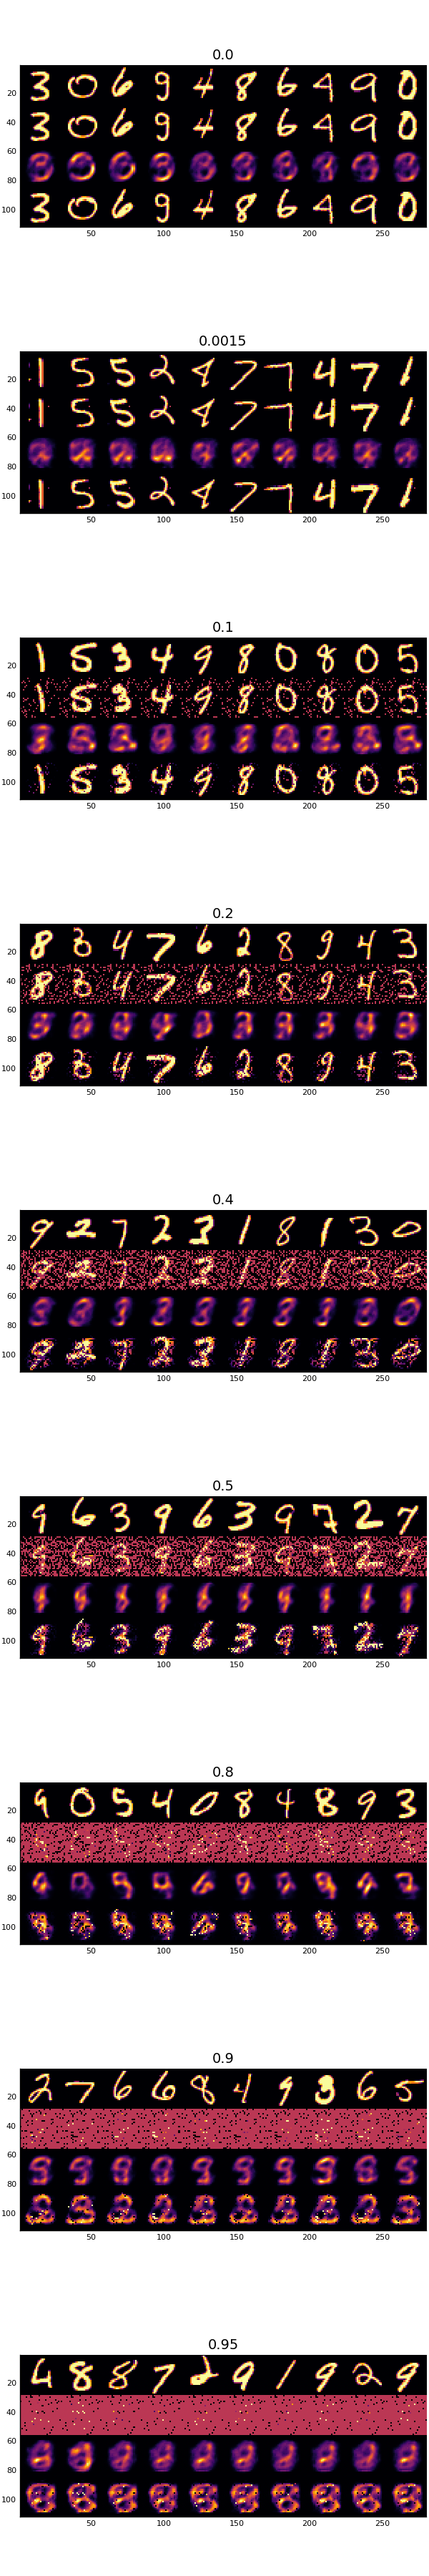

In [299]:
n = 10

ϵ = 1e-8
max_iter = 10

p = []

for i in 1:length(best)
  s = X[:, rand(1:size(X, 2), n)]
  
  lossy = get_lossy(s, masks[i])
  fps, _ = fp_iter(best[i][1], Float64.(lossy), tap_v_fp, tap_h_fp, eps = ϵ, max_iter = max_iter)
  pinned_fps, _ = generate_fps(best[i][1], lossy, masks[i], n_iter = max_iter)
  original = reshape_mnist(s, r = 1, c = n)
    lossy_img = reshape_mnist(lossy, r = 1, c = n)
  fps_img = reshape_mnist(fps, r = 1, c = n)
    pinnef_fps_img = reshape_mnist(pinned_fps, r = 1, c = n)
  img = vcat(original, lossy_img, fps_img, pinnef_fps_img)
  push!(p, plot(img, title = ratios[i]))
end

plot(p..., layout = (length(best), 1), size = (600, 400 * length(best)))

### TAP-100

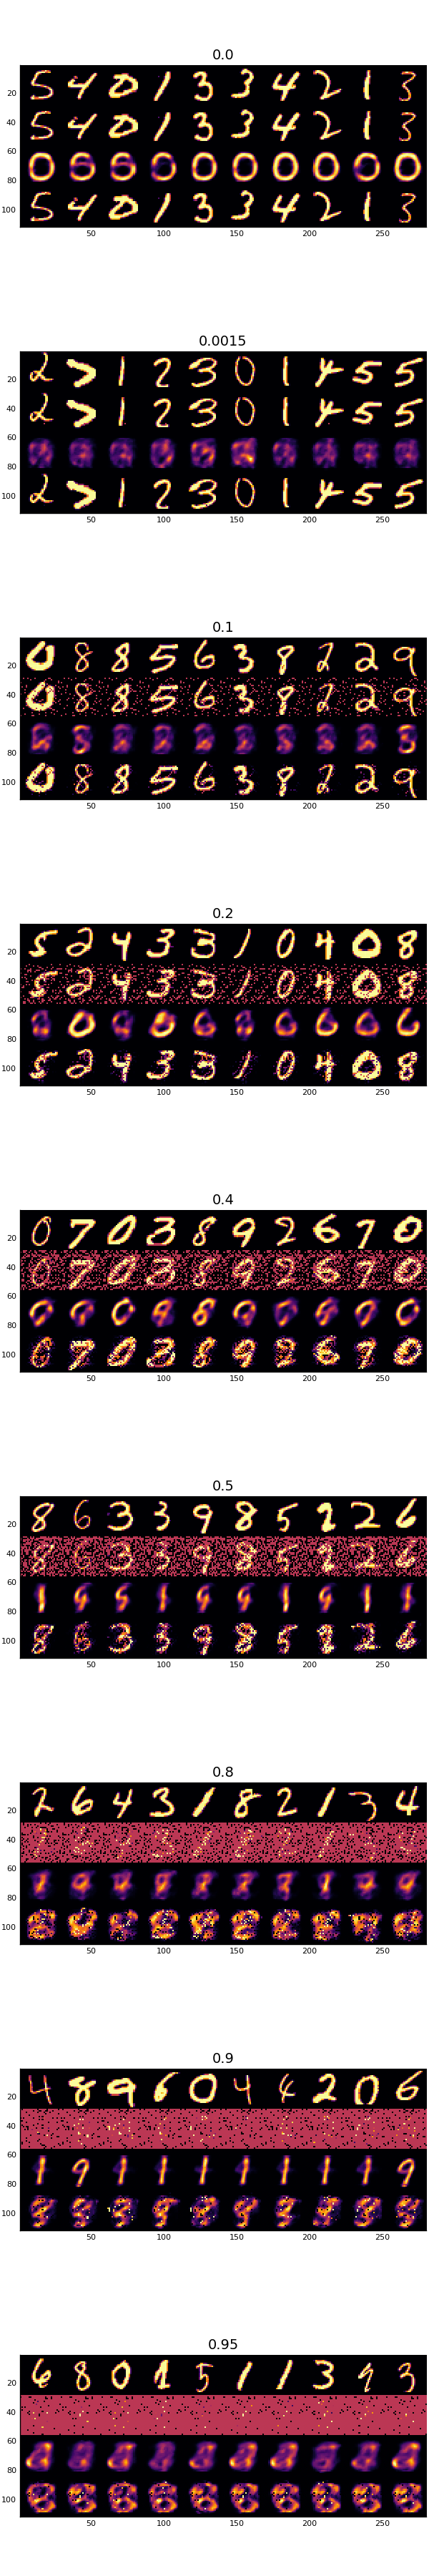

In [309]:
n = 10

ϵ = 1e-8
max_iter = 100

p = []

for i in 1:length(best)
  s = X[:, rand(1:size(X, 2), n)]
  
  lossy = get_lossy(s, masks[i])
  fps, _ = fp_iter(best[i][1], Float64.(lossy), tap_v_fp, tap_h_fp, eps = ϵ, max_iter = max_iter)
  pinned_fps, _ = generate_fps(best[i][1], lossy, masks[i], n_iter = max_iter)
  original = reshape_mnist(s, r = 1, c = n)
    lossy_img = reshape_mnist(lossy, r = 1, c = n)
  fps_img = reshape_mnist(fps, r = 1, c = n)
    pinnef_fps_img = reshape_mnist(pinned_fps, r = 1, c = n)
  img = vcat(original, lossy_img, fps_img, pinnef_fps_img)
  push!(p, plot(img, title = ratios[i]))
end

plot(p..., layout = (length(best), 1), size = (600, 400 * length(best)))

##  TAP-1000

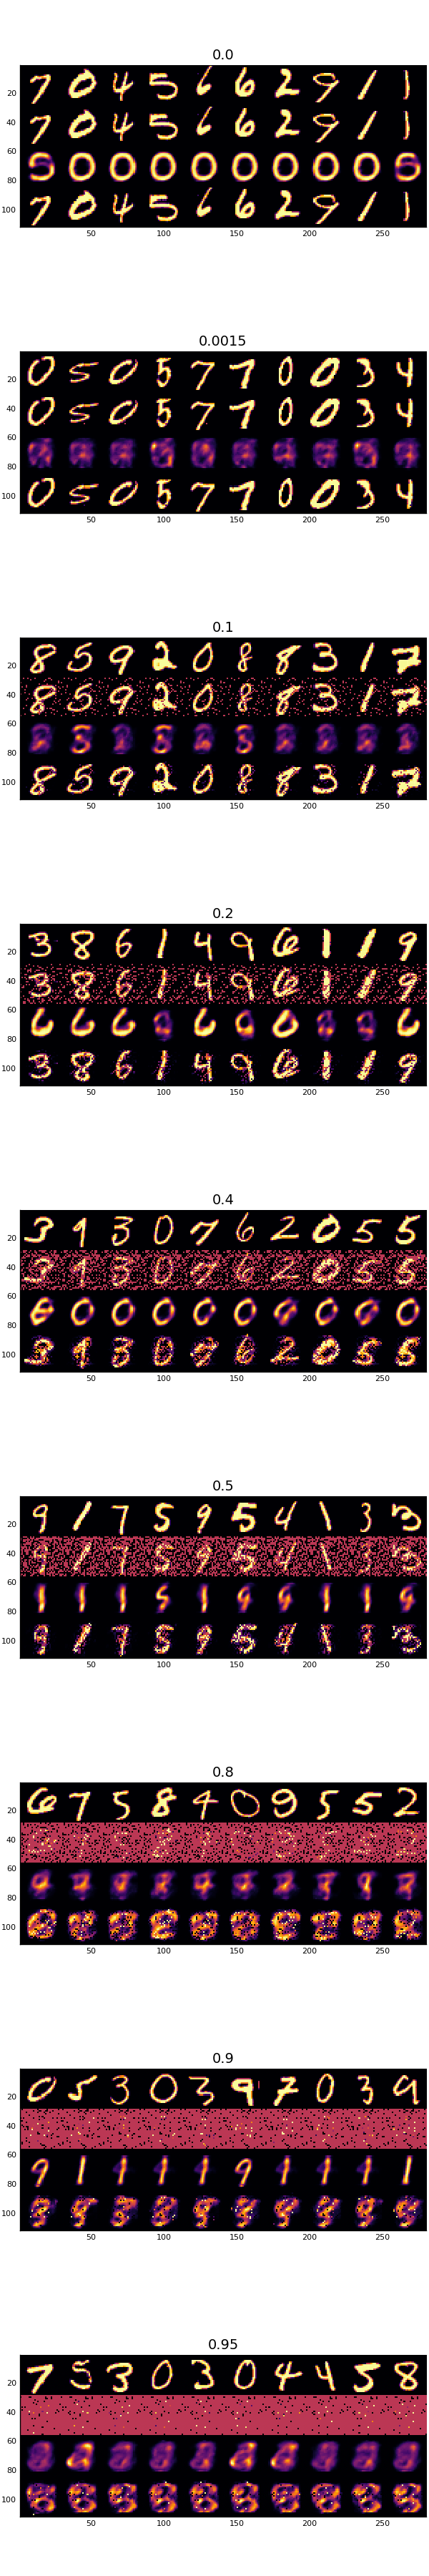

In [310]:
n = 10

ϵ = 1e-8
max_iter = 1000

p = []

for i in 1:length(best)
  s = X[:, rand(1:size(X, 2), n)]
  
  lossy = get_lossy(s, masks[i])
  fps, _ = fp_iter(best[i][1], Float64.(lossy), tap_v_fp, tap_h_fp, eps = ϵ, max_iter = max_iter)
  pinned_fps, _ = generate_fps(best[i][1], lossy, masks[i], n_iter = max_iter)
  original = reshape_mnist(s, r = 1, c = n)
    lossy_img = reshape_mnist(lossy, r = 1, c = n)
  fps_img = reshape_mnist(fps, r = 1, c = n)
    pinnef_fps_img = reshape_mnist(pinned_fps, r = 1, c = n)
  img = vcat(original, lossy_img, fps_img, pinnef_fps_img)
  push!(p, plot(img, title = ratios[i]))
end

plot(p..., layout = (length(best), 1), size = (600, 400 * length(best)))